In [1]:
from tensorflow.python.ops.histogram_ops import histogram_fixed_width
import pandas as pd #this is used to store images as array
import numpy as np
import os      # os will read files
import tensorflow as tf
import cv2     # cv2 will read images
from tensorflow import keras
from tensorflow.keras import layers 
from tensorflow.keras.layers import Dense, Input, InputLayer, Flatten
from tensorflow.keras.models import Sequential, Model
from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import random 
import glob
from skimage import io
import skimage
import keras

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "classes",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)


Found 4096 files belonging to 4 classes.


In [4]:
class_names = dataset.class_names
class_names

['dress', 'pants', 'shorts', 'upper_wear']

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[3 2 0 2 3 3 1 1 3 1 1 1 1 1 0 1 3 1 2 3 2 2 3 3 2 2 3 0 0 1 3 0]


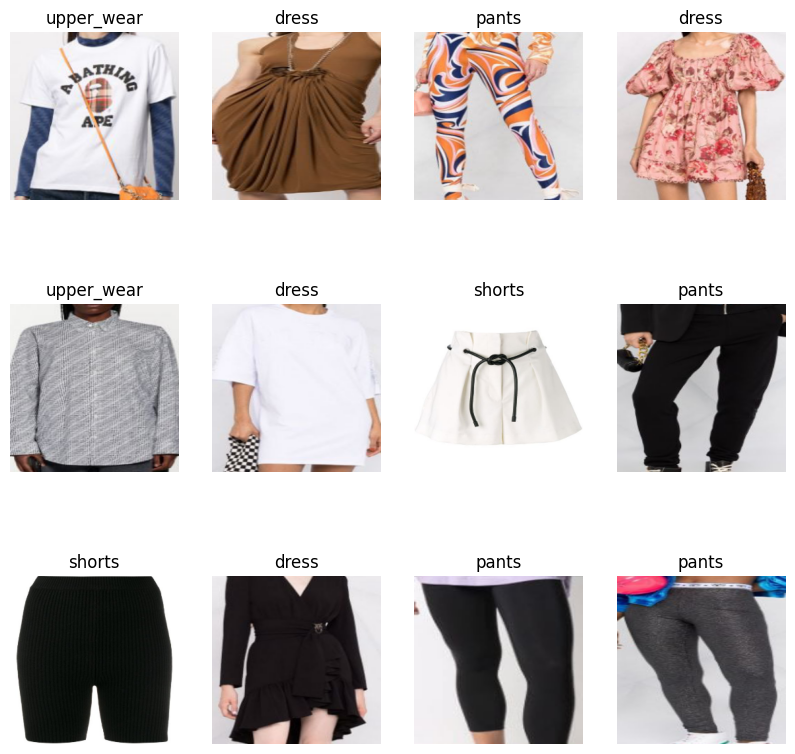

In [6]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [7]:
len(dataset)

128

In [8]:
train_size = 0.8
len(dataset)*train_size

102.4

In [9]:
train_ds = dataset.take(103)
len(train_ds)

103

In [10]:
test_ds = dataset.skip(103)
len(test_ds)

25

In [11]:
val_size=0.1
len(dataset)*val_size

12.8

In [12]:
val_ds = test_ds.take(12)
len(val_ds)

12

In [13]:
test_ds = test_ds.skip(12)
len(test_ds)

13

In [14]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [15]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [16]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [17]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [18]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [20]:
# train_ds = train_ds.map(
#     lambda x, y: (data_augmentation(x, training=True), y)
# ).prefetch(buffer_size=tf.data.AUTOTUNE)

In [21]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 3)
n_classes = 4

model = Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [23]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [24]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=30,
)

Epoch 1/30
102/102 [==============================] - 327s 3s/step - loss: 0.9657 - accuracy: 0.5870 - val_loss: 0.7643 - val_accuracy: 0.7214
Epoch 2/30
102/102 [==============================] - 236s 2s/step - loss: 0.6801 - accuracy: 0.7430 - val_loss: 0.6420 - val_accuracy: 0.7292
Epoch 3/30
102/102 [==============================] - 266s 3s/step - loss: 0.5389 - accuracy: 0.8015 - val_loss: 0.6086 - val_accuracy: 0.7474
Epoch 4/30
102/102 [==============================] - 226s 2s/step - loss: 0.4063 - accuracy: 0.8416 - val_loss: 0.3833 - val_accuracy: 0.8516
Epoch 5/30
102/102 [==============================] - 233s 2s/step - loss: 0.3276 - accuracy: 0.8771 - val_loss: 0.3008 - val_accuracy: 0.8984
Epoch 6/30
102/102 [==============================] - 325s 3s/step - loss: 0.2653 - accuracy: 0.9053 - val_loss: 0.2619 - val_accuracy: 0.9115
Epoch 7/30
102/102 [==============================] - 327s 3s/step - loss: 0.2024 - accuracy: 0.9289 - val_loss: 0.3730 - val_accuracy: 0.8594

first image to predict
actual label: shorts
1/1 [==============================] - 1s 819ms/step
predicted label: shorts


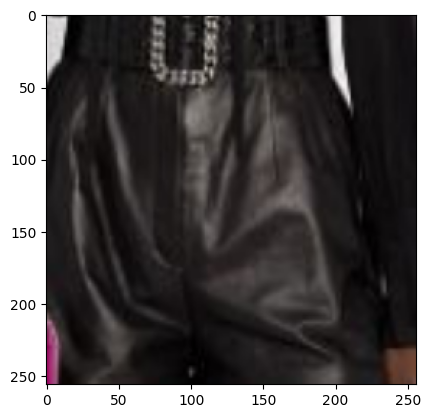

In [25]:
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [26]:
scores = model.evaluate(test_ds)
scores

14/14 [==============================] - 5s 320ms/step - loss: 0.2742 - accuracy: 0.9732


[0.2742246687412262, 0.9732142686843872]

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

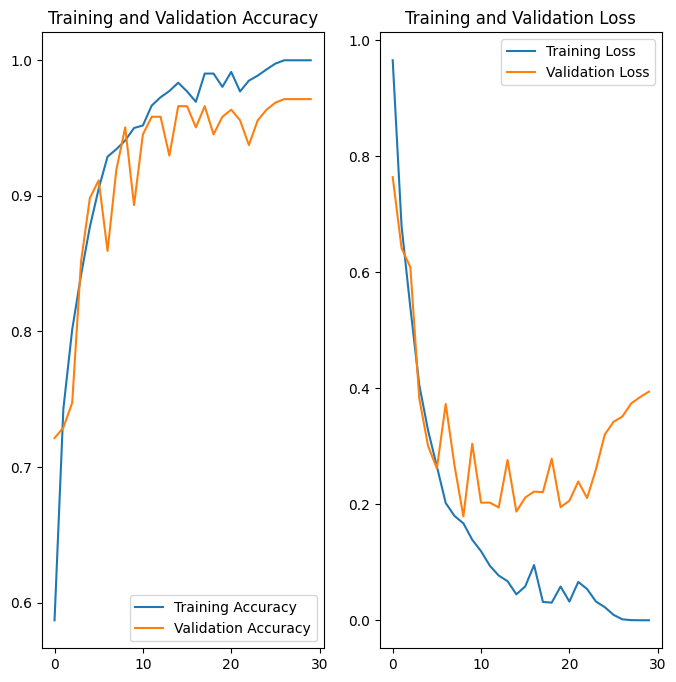

In [28]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(30), acc, label='Training Accuracy')
plt.plot(range(30), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(30), loss, label='Training Loss')
plt.plot(range(30), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [30]:
# Save Model to Disk
# serialize model to JSON
model_json = model.to_json()
with open("model1.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model1.h5")
print("Saved model to disk")
 

Saved model to disk
